In [2]:
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

In [3]:
df = pd.read_csv('english.csv')

In [4]:
df.head(10)

,image,label
0,Img/img001-001.png,0
1,Img/img001-002.png,0
2,Img/img001-003.png,0
3,Img/img001-004.png,0
4,Img/img001-005.png,0
5,Img/img001-006.png,0
6,Img/img001-007.png,0
7,Img/img001-008.png,0
8,Img/img001-009.png,0
9,Img/img001-010.png,0


In [5]:
df.shape

(3410, 2)

In [6]:
img_size = (32, 32)

In [11]:
def load_and_preprocess_image(image_path):
    image_path = 'D:/GitHub/Handwritten_Image_Recognition/model/' + image_path
    img = load_img(image_path, target_size=img_size, color_mode='grayscale')
    return img_to_array(img) / 255.0 

In [12]:
image_paths = df['image'].values
labels = df['label'].values

In [13]:
# Encode character labels to integers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [15]:
imgs = np.array([load_and_preprocess_image(img_path) for img_path in image_paths])

In [16]:
num_label = len(np.unique(labels_encoded))
one_hot_labels = np.eye(num_label)[labels_encoded]

In [17]:
X_train, X_val, y_train, y_val = train_test_split(imgs, one_hot_labels, test_size=0.25, random_state=42)

In [18]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(X_train)

In [19]:
# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_label, activation='softmax')
])

c:\Users\MSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

In [22]:
# Train the model with data augmentation
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/50


c:\Users\MSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.0267 - loss: 4.6219 - val_accuracy: 0.0152 - val_loss: 5.3363 - learning_rate: 0.0010
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0934 - loss: 3.7557 - val_accuracy: 0.0152 - val_loss: 7.5250 - learning_rate: 0.0010
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.1855 - loss: 3.2153 - val_accuracy: 0.0164 - val_loss: 7.8465 - learning_rate: 0.0010
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.2743 - loss: 2.7746 - val_accuracy: 0.0281 - val_loss: 5.6967 - learning_rate: 0.0010
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.3651 - loss: 2.2602 - val_accuracy: 0.1887 - val_loss: 3.1870 - learning_rate: 2.0000e-04
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4274 - loss: 2.0271 - val_accuracy: 0.4338 - val_loss: 2.2421 - learning_rate: 2.0000e-04
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4455 - loss: 1.9762 - val_accura

In [23]:
# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7449 - loss: 0.7957
Validation Loss: 0.7553242444992065
Validation Accuracy: 0.7596717476844788


In [24]:
# Save the label encoder
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [25]:
model.save("recognition_model.h5")

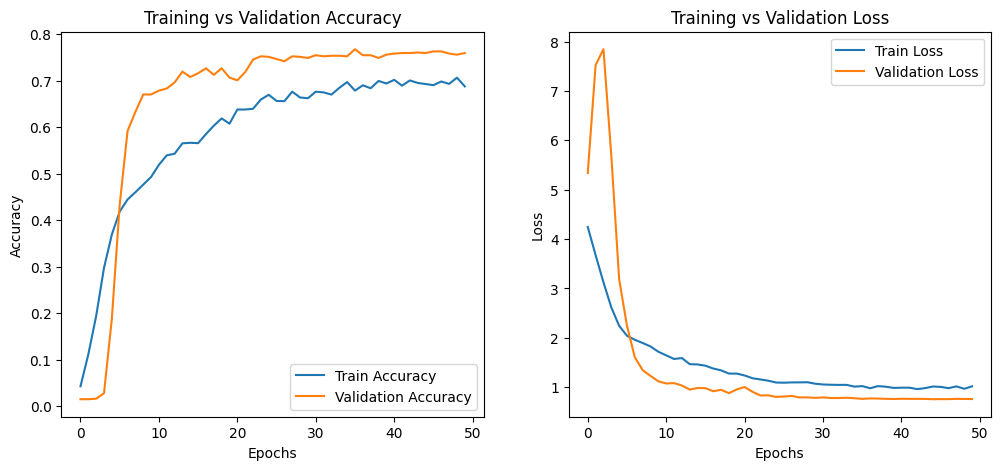

In [26]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

plt.show()